# **II. ANALYSE DE L'AMONT DES SUA**

## **II. 1) Analyse statistique des bases de données réelles des SUA**

### Analyse Mathilde

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
chemin = 'BD_2016_2020_TableauDynamique.xlsx'
df_original = pd.read_excel(chemin, sheet_name="Extraction juin 2016 juin 2020")

In [ ]:
df = df_original.copy()

In [ ]:
df.head()

,Num d'ordre,Date,Heure,Informations du passage->date et heure d'arrivée,Informations du passage->moyen d'arrivée,IAO->motif d'entrée,IAO->motif de venue,Patient->age en année,Antécédent->antécédents médicaux,Antécédent->antécédents chirurgicaux,...,Informations du passage->CAC du séjour,Informations du passage->date et heure de sortie,Informations du passage->date début prise en charge médicale,Informations du passage->dossier dans l'hôpital,Orientation->type d'orientation,Orientation->destination,Orientation->tansfert vers le service,Orientation->transfert vers l'hôpital,Patient->code postal de la ville,Patient->nom de la ville
0,1,2016-06-01,00:16:00,2016-06-01 00:16:00,AMBULANCE PRIVEE,"Malaise, difficulté respi, palpitation, Pas de...",Cardiologie: Palpitations Malaise,33,NaN,NaN,...,3093.0,42522.176389,42522.043750,NaN,RETOUR DOMICILE,RETOUR DOMICILE,NaN,NaN,59139,WATTIGNIES
1,2,2016-06-01,00:18:00,2016-06-01 00:18:00,AMBULANCE PRIVEE,"AEG, Hyperthermie et difficulté respi en maiso...",Maladies infectieuses: Hyperthermie,78,NaN,NaN,...,3102.0,42522.461806,42522.093056,NaN,TRANSFERT EXTERNE,Transfert CLINIQUE DUBOIS (LILLE) Motif: Conve...,NaN,CLINIQUE DUBOIS,59310,ORCHIES
2,3,2016-06-01,00:36:00,2016-06-01 00:36:00,POMPIERS,NaN,NaN,77,NaN,NaN,...,3102.0,42522.127778,NaN,NaN,TRANSFERT INTERNE,Admis(e) en NEUROLOGIE B 5 EST (3281/CAC),NEUROLOGIE B 5 EST,NaN,59480,LA BASSEE
3,4,2016-06-01,00:43:00,2016-06-01 00:43:00,MOYENS PERSONNELS,"1A, Hyperthermie ne cédant pas au paracetamol,...",Maladies infectieuses: Hyperthermie,38,NaN,NaN,...,3093.0,42522.201389,42522.081250,NaN,RETOUR DOMICILE,RETOUR DOMICILE,NaN,NaN,59136,WAVRIN
4,5,2016-06-01,01:16:00,2016-06-01 01:16:00,AMBULANCE PRIVEE,"Douleur bras gauche et mollet gauche, hémiplég...",Cardiologie: Phlébite,69,décembre 2007 : infarctus capsulo caudé droit ...,NaN,...,3102.0,42522.663194,42522.107639,NaN,RETOUR DOMICILE,RETOUR DOMICILE,NaN,NaN,59130,LAMBERSART


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336253 entries, 0 to 336252
Data columns (total 41 columns):
 #   Column                                                                        Non-Null Count   Dtype         
---  ------                                                                        --------------   -----         
 0   Num d'ordre                                                                   336253 non-null  int64         
 1   Date                                                                          336253 non-null  datetime64[ns]
 2   Heure                                                                         336253 non-null  object        
 3    Informations du passage->date et heure d'arrivée                             336253 non-null  datetime64[ns]
 4    Informations du passage->moyen d'arrivée                                     334907 non-null  object        
 5    IAO->motif d'entrée                                                          3

In [ ]:
df.isna().sum()

Num d'ordre                                                                          0
Date                                                                                 0
Heure                                                                                0
 Informations du passage->date et heure d'arrivée                                    0
 Informations du passage->moyen d'arrivée                                         1346
 IAO->motif d'entrée                                                             24451
 IAO->motif de venue                                                             28719
 Patient->age en année                                                               0
 Antécédent->antécédents médicaux                                               233630
 Antécédent->antécédents chirurgicaux                                           265119
 Constante->Surveillances->PAS/PAD adultes (première valeur)                     93635
 Constante->Surveillances->FC adultes (prem

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# remarques :

# 1) bcp de données non-numériques
# --> variables quali : encoder ça ?
# --> variables quanti :
  #  motif entrée,
  #  motif venue,
  #  antécédents médicaux,
  #  antécédents chirurgicaux,
  #  Orientation->destination
  #  Orientation->tansfert vers le service
  #  Orientation->transfert vers l'hôpital
  #  nom de la ville

# 2) renommer variables prcq là c'est le bordèle

# 3) pas de duplicats donc lourd

# 4) par contre, bcp de na !!

# 5) variable cible ? j'aurais mis le temps pass aux urgences donc date/heure d'arrivée - date/heure de sortie mais à voir

# 6) sélectionner variables indicateurs : en fonction du niveau de corrélation avec notre var cible ? avec bon sens ? ACP ?


In [ ]:
# Renommer les colonnes : supprimer espaces, flèches, caractères spéciaux
import re

def clean_column_name(col):
    """Nettoie le nom de colonne : supprime espaces, flèches, caractères spéciaux"""
    # Remplacer les flèches par underscore
    col = col.replace('->', '_')
    col = col.replace('→', '_')
    # Remplacer les espaces par underscore
    col = col.replace(' ', '_')
    # Supprimer les caractères spéciaux
    col = re.sub(r'[^a-zA-Z0-9_]', '', col)
    # Supprimer les underscores multiples
    col = re.sub(r'_+', '_', col)
    # Transformer en minuscules
    col = col.lower()
    return col

df.columns = [clean_column_name(col) for col in df.columns]
print("Colonnes renommées :")
print(df.columns.tolist())

Colonnes renommées :
['num_dordre', 'date', 'heure', '_informations_du_passage_date_et_heure_darrive', '_informations_du_passage_moyen_darrive', '_iao_motif_dentre', '_iao_motif_de_venue', '_patient_age_en_anne', '_antcdent_antcdents_mdicaux', '_antcdent_antcdents_chirurgicaux', '_constante_surveillances_paspad_adultes_premire_valeur', '_constante_surveillances_fc_adultes_premire_valeur', '_constante_surveillances_temprature_adultes_premire_valeur', '_constante_surveillances_sao2_adultes_premire_valeur', '_constante_surveillances_frquence_respiratoire_premire_valeur', '_diagnostic_code_ccmu', '_localisation_salles', '_localisation_date_dentre_en_box', '_anamnse_texte', '_iao_observation', '_examens_complmentaires_a_des_examens_de_biologie', '_examens_complmentaires_a_des_examens_de_radiologie', '_examens_complmentaires_a_des_examens_dchographie', '_examens_complmentaires_a_des_examens_de_scanner', '_examens_complmentaires_a_des_examens_dirm', '_examens_complmentaires_a_des_avis_de_spci

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336253 entries, 0 to 336252
Data columns (total 41 columns):
 #   Column                                                                     Non-Null Count   Dtype         
---  ------                                                                     --------------   -----         
 0   num_dordre                                                                 336253 non-null  int64         
 1   date                                                                       336253 non-null  datetime64[ns]
 2   heure                                                                      336253 non-null  object        
 3   _informations_du_passage_date_et_heure_darrive                             336253 non-null  datetime64[ns]
 4   _informations_du_passage_moyen_darrive                                     334907 non-null  object        
 5   _iao_motif_dentre                                                          311802 non-null  object  

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df.head(20)

# à tej : date, heure, iao_motif_dentre( de tte façon on peut pas l'encoder) _anamnse_texte	(dossier patient), _iao_observation, _examens_complmentaires_date_et_heure_de_premire_prescription_de_biologie	

# à encoder : iao_motif_venue, 
# --> _examens_complmentaires_a_des_examens_de_biologie --> mettre en booléen (Encoder)

# à voir : antcdents medicaux, chirurgicaux, _localisation_salles	

# à séparer ; _constante_surveillances_paspad_adultes_premire_valeur

# ne pas suppr les Nan pour : _constante_surveillances_frquence_respiratoire_premire_valeur	et antcdents medicaux, chirurgicaux, 

,num_dordre,date,heure,_informations_du_passage_date_et_heure_darrive,_informations_du_passage_moyen_darrive,_iao_motif_dentre,_iao_motif_de_venue,_patient_age_en_anne,_antcdent_antcdents_mdicaux,_antcdent_antcdents_chirurgicaux,_constante_surveillances_paspad_adultes_premire_valeur,_constante_surveillances_fc_adultes_premire_valeur,_constante_surveillances_temprature_adultes_premire_valeur,_constante_surveillances_sao2_adultes_premire_valeur,_constante_surveillances_frquence_respiratoire_premire_valeur,_diagnostic_code_ccmu,_localisation_salles,_localisation_date_dentre_en_box,_anamnse_texte,_iao_observation,_examens_complmentaires_a_des_examens_de_biologie,_examens_complmentaires_a_des_examens_de_radiologie,_examens_complmentaires_a_des_examens_dchographie,_examens_complmentaires_a_des_examens_de_scanner,_examens_complmentaires_a_des_examens_dirm,_examens_complmentaires_a_des_avis_de_spcialistes,_examens_complmentaires_date_et_heure_de_premire_prescription_de_biologie,_examens_complmentaires_date_et_heure_de_premier_prlvement_de_biologie,_diagnostic_diagnostic_principal_code_diagnostic,_diagnostic_diagnostic_principal_intitul,_informations_du_passage_cac_dadmission,_informations_du_passage_cac_du_sjour,_informations_du_passage_date_et_heure_de_sortie,_informations_du_passage_date_dbut_prise_en_charge_mdicale,_informations_du_passage_dossier_dans_lhpital,_orientation_type_dorientation,_orientation_destination,_orientation_tansfert_vers_le_service,_orientation_transfert_vers_lhpital,_patient_code_postal_de_la_ville,_patient_nom_de_la_ville
0,1,2016-06-01,00:16:00,2016-06-01 00:16:00,AMBULANCE PRIVEE,"Malaise, difficulté respi, palpitation, Pas de...",Cardiologie: Palpitations Malaise,33,NaN,NaN,110/56,52,34.9,97,NaN,1,"((Attente pré IOA,01/06/2016 00:16,01/06/2016 ...",42522.045833,MDC: Dyspnée aiguë et palpitations ATCDS: ...,NaN,oui,oui,non,non,non,non,42522.062500,42522.065972,R06.0,Dyspnée,ACCUEIL SURVEILLANCE ET ADMISSION URGENCE ADUL...,3093.0,42522.176389,42522.043750,NaN,RETOUR DOMICILE,RETOUR DOMICILE,NaN,NaN,59139,WATTIGNIES
1,2,2016-06-01,00:18:00,2016-06-01 00:18:00,AMBULANCE PRIVEE,"AEG, Hyperthermie et difficulté respi en maiso...",Maladies infectieuses: Hyperthermie,78,NaN,NaN,90/41,77,36.3,98,NaN,2,"((Attente pré IOA,01/06/2016 00:18,01/06/2016 ...",42522.063889,vient pour hyperthermie ATCD: DID retard ...,NaN,oui,oui,non,non,non,non,42522.065278,42522.065278,R50.9,"Fièvre, sans précision",ACCUEIL SURVEILLANCE ET ADMISSION URGENCE ADUL...,3102.0,42522.461806,42522.093056,NaN,TRANSFERT EXTERNE,Transfert CLINIQUE DUBOIS (LILLE) Motif: Conve...,NaN,CLINIQUE DUBOIS,59310,ORCHIES
2,3,2016-06-01,00:36:00,2016-06-01 00:36:00,POMPIERS,NaN,NaN,77,NaN,NaN,137/77,97,36.5,96,21,2,"((Attente pré IOA,01/06/2016 00:36,01/06/2016 ...",42522.028472,NaN,NaN,non,non,non,non,non,oui,NaN,NaN,R47.1,Dysarthrie et anarthrie,ACCUEIL SURVEILLANCE ET ADMISSION URGENCE ADUL...,3102.0,42522.127778,NaN,NaN,TRANSFERT INTERNE,Admis(e) en NEUROLOGIE B 5 EST (3281/CAC),NEUROLOGIE B 5 EST,NaN,59480,LA BASSEE
3,4,2016-06-01,00:43:00,2016-06-01 00:43:00,MOYENS PERSONNELS,"1A, Hyperthermie ne cédant pas au paracetamol,...",Maladies infectieuses: Hyperthermie,38,NaN,NaN,117/71,118,38.2,98,NaN,1,"((Attente pré IOA,01/06/2016 00:43,01/06/2016 ...",42522.066667,patient de 38 ans appelant le SAMU pour épisod...,NaN,oui,non,non,non,non,non,42522.069444,42522.069444,L98.8,Autres affections précisées de la peau et du t...,ACCUEIL SURVEILLANCE ET ADMISSION URGENCE ADUL...,3093.0,42522.201389,42522.081250,NaN,RETOUR DOMICILE,RETOUR DOMICILE,NaN,NaN,59136,WAVRIN
4,5,2016-06-01,01:16:00,2016-06-01 01:16:00,AMBULANCE PRIVEE,"Douleur bras gauche et mollet gauche, hémiplég...",Cardiologie: Phlébite,69,décembre 2007 : infarctus capsulo caudé droit ...,NaN,137/79,70,36.1,97,NaN,2,"((Attente pré IOA,01/06/2016 01:16,01/06/2016 ...",42522.066667,Patiente de 69 ans amenée pour douleur membre ...,NaN,oui,non,non,non,non,oui,42522.065278,42522.065972,M79.62,Douleur au n

In [ ]:
df["target"] = df["_informations_du_passage_date_et_heure_de_sortie"] - df["_informations_du_passage_date_et_heure_darrive "]

In [ ]:
# Voir le contenu et le type de _informations_du_passage_date_et_heure_de_sortie
print("Type :", df["_informations_du_passage_date_et_heure_de_sortie"].dtype)
print("\nPremières valeurs :")
print(df["_informations_du_passage_date_et_heure_de_sortie"].head(10))
print("\nExemple détaillé :")
print(df["_informations_du_passage_date_et_heure_de_sortie"].iloc[0])

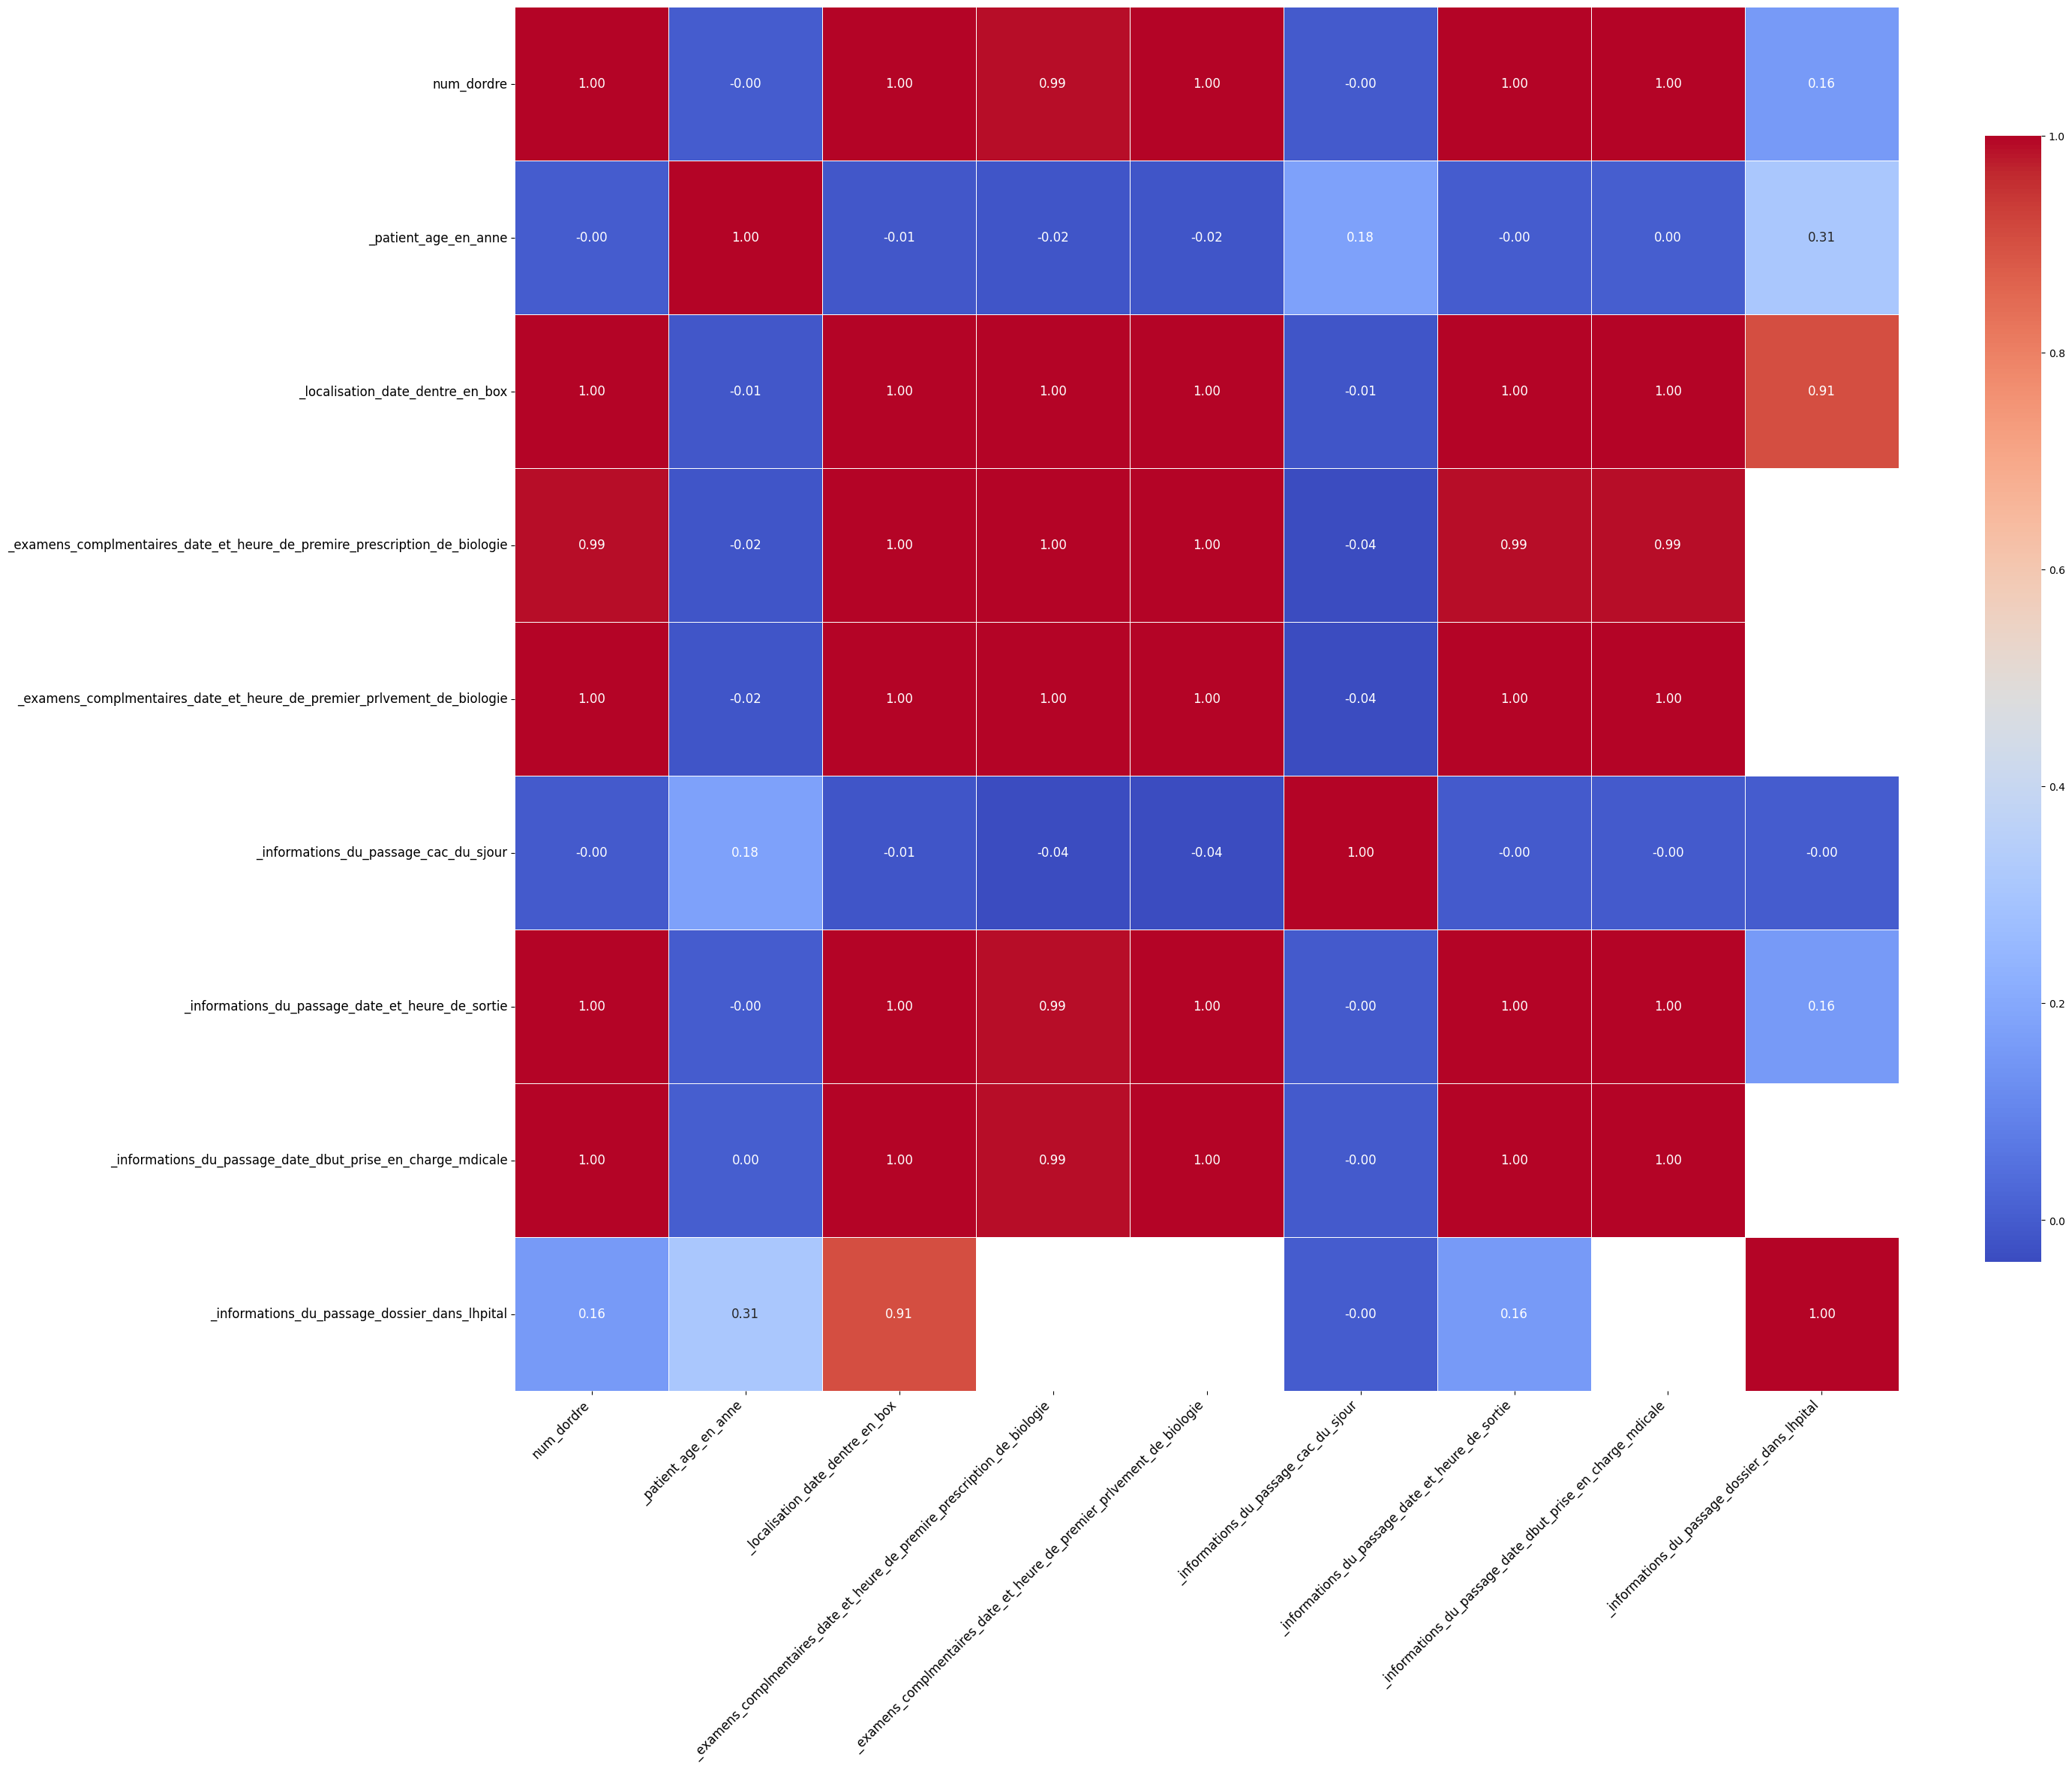

In [ ]:
# matrice de corrélation
plt.figure(figsize=(30, 24))
sns.heatmap(df.select_dtypes(include=[float, int]).corr(method='pearson'), 
            cmap='coolwarm', annot=True, fmt='.2f', square=True, 
            cbar_kws={'shrink': 0.8}, annot_kws={'size': 12}, linewidths=0.5)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Analyse Tom

### Indicateur 1

In [ ]:
# Les courbes

In [ ]:
# Analyse

In [ ]:
# Intérêt de l’étude

### Indicateur 2

In [ ]:
# Les courbes

In [ ]:
# Analyse

In [ ]:
# Intérêt de l'étude

### Indicateur 3

In [ ]:
# Les courbes

In [ ]:
# Analyse

In [ ]:
# Intérêt de l'étude